In [1]:
import pandas as pd
import matplotlib.pyplot as plt



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import average_precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as impipeline



In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    average_precision_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [3]:
fraud_df = pd.read_csv(r"c:\Users\hp\Music\Adey Innovations inc\Fraud-Detection-for-E-commerce-and-Bank-Transactions\data\processed\fraud_processed.csv")
 
fraud_df = pd.read_csv(
    r"c:\Users\hp\Music\Adey Innovations inc\Fraud-Detection-for-E-commerce-and-Bank-Transactions\data\processed\fraud_processed.csv",
    parse_dates=["purchase_time", "signup_time"]
)

print(fraud_df.shape)
print(fraud_df["class"].value_counts(normalize=True))



(151112, 17)
class
0    0.906354
1    0.093646
Name: proportion, dtype: float64


In [4]:
credit_df = pd.read_csv(r"c:\Users\hp\Music\Adey Innovations inc\Fraud-Detection-for-E-commerce-and-Bank-Transactions\data\processed\creditcard_features.csv")

X_credit = credit_df.drop(columns=["Class"])
y_credit = credit_df["Class"]


In [5]:
datetime_cols = ["purchase_time", "signup_time"]

fraud_df = fraud_df.drop(columns=datetime_cols)


In [6]:
#Separate features and target
TARGET = "class"

X = fraud_df.drop(columns=[TARGET])
y = fraud_df[TARGET]

In [7]:
#Train-test split (stratified)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [8]:
#Encode categorical + scale numeric (THIS FIXES YOUR ERROR)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat_cols = X_train.select_dtypes(include="object").columns.tolist()
num_cols = X_train.select_dtypes(exclude="object").columns.tolist()

print("Categorical:", cat_cols)
print("Numerical:", num_cols)


Categorical: ['device_id', 'source', 'browser', 'sex', 'country']
Numerical: ['user_id', 'purchase_value', 'age', 'ip_address', 'hour_of_day', 'day_of_week', 'time_since_signup', 'txn_count_1h', 'txn_count_24h']


In [9]:
#Build preprocessing pipeline
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)


In [10]:
#Handle class imbalance (SMOTE on TRAIN ONLY)
'''Fraud is rare

Undersampling would throw away valuable normal transactions

SMOTE creates synthetic minority samples'''
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


In [11]:
#Logistic Regression pipeline (FIXED)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, average_precision_score, confusion_matrix

log_pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", LogisticRegression(max_iter=1000))
])

log_pipeline.fit(X_train, y_train)

log_pred = log_pipeline.predict(X_test)
log_prob = log_pipeline.predict_proba(X_test)[:, 1]

print("Logistic Regression")
print("F1:", f1_score(y_test, log_pred))
print("AUC-PR:", average_precision_score(y_test, log_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, log_pred))


Logistic Regression
F1: 0.6614529738629348
AUC-PR: 0.62085532625146
Confusion Matrix:
 [[26971   422]
 [ 1223  1607]]


In [12]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

rf = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", rf)
])

param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

print("Best params:", grid_search.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 100}


In [14]:
#Evaluate best Random Forest
rf_pred = best_rf.predict(X_test)
rf_prob = best_rf.predict_proba(X_test)[:, 1]

print("Random Forest")
print("F1:", f1_score(y_test, rf_pred))
print("AUC-PR:", average_precision_score(y_test, rf_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_pred))


Random Forest
F1: 0.6897018970189702
AUC-PR: 0.6353469616859942
Confusion Matrix:
 [[27322    71]
 [ 1303  1527]]


In [15]:
#Ensemble Model — Random Forest
''' Handles nonlinear patterns

Robust to noise

Good balance between performance and explainability'''
#Model + basic tuning
rf = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20]
}


In [17]:
#Cross-validation results (optional but recommended)
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    best_rf,
    X_train,
    y_train,
    cv=cv,
    scoring="average_precision"
)

print("CV AUC-PR mean:", cv_scores.mean())
print("CV AUC-PR std:", cv_scores.std())


CV AUC-PR mean: 0.630142609139013
CV AUC-PR std: 0.009410645598499372


In [ ]:
#Extract feature names after preprocessing
# Get preprocessing step
preprocessor = best_rf.named_steps["prep"]

# Numeric feature names
num_features = preprocessor.transformers_[0][2]

# Categorical feature names after OHE
cat_encoder = preprocessor.transformers_[1][1]
cat_features = cat_encoder.get_feature_names_out(preprocessor.transformers_[1][2])

feature_names = np.concatenate([num_features, cat_features])



In [27]:
#Get Random Forest feature importance
rf_model = best_rf.named_steps["model"]
importances = rf_model.feature_importances_

fi_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
)


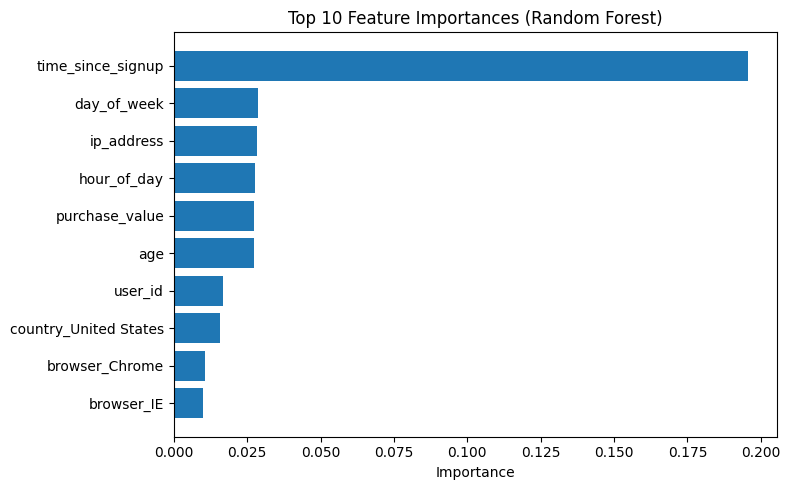

In [28]:
#Plot top 10
plt.figure(figsize=(8, 5))
plt.barh(fi_df.head(10)["feature"], fi_df.head(10)["importance"])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [30]:
X_test_transformed = preprocessor.transform(X_test)

print(type(X_test_transformed))
print(X_test_transformed.shape)


<class 'scipy.sparse._csr.csr_matrix'>
(30223, 111590)


In [31]:
def get_feature_names(preprocessor):
    feature_names = []

    for name, transformer, cols in preprocessor.transformers_:
        if name == "num":
            feature_names.extend(cols)

        elif name == "cat":
            encoder = transformer
            feature_names.extend(
                encoder.get_feature_names_out(cols)
            )

    return feature_names


In [32]:
feature_names = get_feature_names(preprocessor)
len(feature_names)


111590

In [33]:
OneHotEncoder(handle_unknown="ignore", sparse_output=False)


,"categories categories: 'auto' or a list of array-like, default='auto'Categories (unique values) per feature:- 'auto' : Determine categories automatically from the training data.- list : ``categories[i]`` holds the categories expected in the ith column. The passed categories should not mix strings and numeric values within a single feature, and should be sorted in case of numeric values.The used categories can be found in the ``categories_`` attribute... versionadded:: 0.20",'auto'
,"drop drop: {'first', 'if_binary'} or an array-like of shape (n_features,), default=NoneSpecifies a methodology to use to drop one of the categories perfeature. This is useful in situations where perfectly collinearfeatures cause problems, such as when feeding the resulting datainto an unregularized linear regression model.However, dropping one category breaks the symmetry of the originalrepresentation and can therefore induce a bias in downstream models,for instance for penalized linear classification or regression models.- None : retain all features (the default).- 'first' : drop the first category in each feature. If only one category is present, the feature will be dropped entirely.- 'if_binary' : drop the first category in each feature with two categories. Features with 1 or more than 2 categories are left intact.- array : ``drop[i]`` is the category in feature ``X[:, i]`` that should be dropped.When `max_categories` or `min_frequency` is configured to groupinfrequent categories, the dropping behavior is handled after thegrouping... versionadded:: 0.21 The parameter `drop` was added in 0.21... versionchanged:: 0.23 The option `drop='if_binary'` was added in 0.23... versionchanged:: 1.1 Support for dropping infrequent categories.",None
,"sparse_output sparse_output: bool, default=TrueWhen ``True``, it returns a :class:`scipy.sparse.csr_matrix`,i.e. a sparse matrix in ""Compressed Sparse Row"" (CSR) format... versionadded:: 1.2 `sparse` was renamed to `sparse_output`",False
,"dtype dtype: number type, default=np.float64Desired dtype of output.",<class 'numpy.float64'>
,"handle_unknown handle_unknown: {'error', 'ignore', 'infrequent_if_exist', 'warn'}, default='error'Specifies the way unknown categories are handled during :meth:`transform`.- 'error' : Raise an error if an unknown category is present during transform.- 'ignore' : When an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will be all zeros. In the inverse transform, an unknown category will be denoted as None.- 'infrequent_if_exist' : When an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will map to the infrequent category if it exists. The infrequent category will be mapped to the last position in the encoding. During inverse transform, an unknown category will be mapped to the category denoted `'infrequent'` if it exists. If the `'infrequent'` category does not exist, then :meth:`transform` and :meth:`inverse_transform` will handle an unknown category as with `handle_unknown='ignore'`. Infrequent categories exist based on `min_frequency` and `max_categories`. Read more in the :ref:`User Guide `.- 'warn' : When an unknown category is encountered during transform a warning is issued, and the encoding then proceeds as described for `handle_unknown=""infrequent_if_exist""`... versionchanged:: 1.1 `'infrequent_if_exist'` was added to automatically handle unknown categories and infrequent categories... versionadded:: 1.6 The option `""warn""` was added in 1.6.",'ignore'
,"min_frequency min_frequency: int or float, default=NoneSpecifies the minimum frequency below which a category will beconsidered infrequent.- If `int`, categories with a smaller cardinality will be considered infrequent.- If `float`, categories with a smaller cardinality than `min_frequency * n_samples` will be considered infrequent... versionadded:: 1.1 Read more in the :ref:`User Guide `.",None
,"max_cate

In [38]:
rf_model = best_rf.named_steps["model"]
preprocessor = best_rf.named_steps["prep"]


In [35]:
rf_model = best_rf.named_steps["model"]
prep = best_rf.named_steps["prep"]

X_test_sparse = prep.transform(X_test)


In [39]:
print(type(X_test_sparse))
print(X_test_sparse.dtype)


<class 'scipy.sparse._csr.csr_matrix'>
float64


In [40]:
import numpy as np

# sample small subset
np.random.seed(42)
sample_idx = np.random.choice(X_test_sparse.shape[0], 500, replace=False)

X_shap = X_test_sparse[sample_idx]

# Convert ONLY the sample to dense + float32
X_shap = X_shap.toarray().astype(np.float32)


In [45]:
import numpy as np

np.random.seed(42)

# Sample 300–500 rows only
sample_size = 300
sample_idx = np.random.choice(X_test_sparse.shape[0], sample_size, replace=False)

X_shap_sparse = X_test_sparse[sample_idx]


In [47]:
X_shap = X_shap_sparse.toarray().astype(np.float32)


In [ ]:
import shap

rf_model = best_rf.named_steps["model"]

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_shap)


In [ ]:
shap.summary_plot(
    shap_values[1],
    X_shap,
    feature_names=feature_names,
    max_display=10
)
